In [16]:
#@title Run to setup question dependencies
!pip install --upgrade -q tfds-nightly tensorflow-addons

     |████████████████████████████████| 4.0 MB 8.0 MB/s 


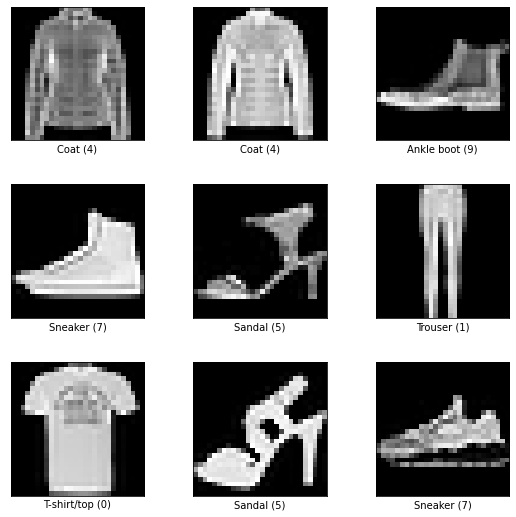

In [17]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
 #@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import tensorflow as tf
import tensorflow_addons as tfa
import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]
__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
      ),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model

In [19]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, verbose: int = 1, lr: float = None, lr_decay: float = None):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')
  if verbose > 1:
    model.summary()
  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=10,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )
  # delete model
  del model
  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'Best test accuracy: {best_history["val_accuracy"]}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)

**Importing Libraries**

In [20]:
import pandas as pd
from itertools import permutations
import random

**Train a genome and return parameters and accuracy**

In [21]:
def generate_random_and_train(space):
  rand_int = random.randint(0,len(space)-1)
  rand_genome = space[rand_int]
  __fr_model_genome = rand_genome

  __fr_lr = 1e-3
  __fr_lr_decay = 0.1 
  returned_value = train_model(__fr_model_genome,verbose=1,lr=__fr_lr, lr_decay=__fr_lr_decay)
  returned_value= list(returned_value)
  returned_value.append(rand_genome)
  #(test_Accuracy,validation_accuracy,parameter,genome)<- returned_vale
  return returned_value


**Calculate Parameter count percentage difference**

In [22]:
def parameter_change_percentage(prev,new):
  return ((new-prev)/prev)*100

**Calculate accuracy difference**

In [23]:
def accuracy_difference(prev,new):
  return new-prev

**Hill climbing Search**

In [24]:
def hill_climbing_search(space):
  #Initialization
  print("...........................initialization............................")
  prev_returned_value = generate_random_and_train(space)
  prev_test_accuracy = prev_returned_value[0]
  prev_parameters = prev_returned_value[2]
  prev_genome = prev_returned_value[3]

  while(1):
    new_returned_value = generate_random_and_train(space)
    new_test_accuracy = new_returned_value[0]
    new_parameters = new_returned_value[2]
    new_genome = new_returned_value[3]

    if new_test_accuracy<prev_test_accuracy:
      break
    elif (new_test_accuracy>prev_test_accuracy) and (parameter_change_percentage(prev_parameters,new_parameters) > accuracy_difference(prev_test_accuracy,new_test_accuracy)):
      #print("parameter change " ,parameter_change_percentage(prev_parameters,new_parameters))
      #print("Accuracy change ",  accuracy_difference(prev_test_accuracy,new_test_accuracy))
      break
    else:
      prev_returned_value=new_returned_value
      prev_test_accuracy = new_test_accuracy
      prev_parameters = new_parameters
      prev_genome=new_genome

  return prev_returned_value

In [25]:
def new_genome_prediction(first,second):
    a=first.split(";")
    del a[-1]
    b=second.split(";")
    del b[-1]

    RC=[]
    NC=[]
    FL=[]
    total_layers = random.randint(4,8)
    new_genome=[]

    x= a+b
    for each in x:
      each=each+";"
      if each[0]=='R':
        RC.append(each)
      elif each[0]=='N':
        NC.append(each)
      elif each[0]=='F':
        FL.append(each)

    for i in range(total_layers-3):
      NC_index = random.randint(0,len(NC)-1)
      new_genome.append(NC[NC_index])
    for i in range(2):
      RC_index = random.randint(0,len(RC)-1)
      new_genome.append(RC[RC_index])
    
    permt_list = list(permutations(new_genome))
    permt_list =[list(x) for x in permt_list ]
    new_genome = permt_list[random.randint(0,len(permt_list)-1)]

    FL_index=random.randint(0,len(FL)-1)
    new_genome.append(FL[FL_index])
    new_genome =''.join(new_genome)

    #print(new_genome)
    return new_genome
   

**Find best two genomes from initial population**

In [26]:
def best_two(genomes):
  accuracy_list_with_index=[]
  for i in range(len(genomes)):
    gen = genomes.loc[i][0]
    __fr_model_genome = gen
    __fr_lr = 1e-3
    __fr_lr_decay = 0.1 
    returned_value = train_model(__fr_model_genome,lr=__fr_lr, lr_decay=__fr_lr_decay)
    accuracy_list_with_index.append((returned_value[0],i,returned_value[2]))
    accuracy_list_with_index= sorted(accuracy_list_with_index,reverse=True)

  first_genome_index =  accuracy_list_with_index[0][1]
  second_genome_index = accuracy_list_with_index[1][1]
    
  #first_genome_string,second_genome_string,first_genome_accuracy,second_genome_accuracy,first_genome_parameter,second_genome_parameter
  return genomes.loc[first_genome_index][0],genomes.loc[second_genome_index][0],accuracy_list_with_index[0][0],accuracy_list_with_index[1][0],accuracy_list_with_index[0][2],accuracy_list_with_index[1][2]
    

**Create mutated space from parent genomes**

In [33]:
def mutated_space(first,second):
  space=[]
  while len(space)<=10:
    new_str= new_genome_prediction(first,second)
    if new_str not in space:
        space.append(new_genome_prediction(first,second))
  return space

**Read initial population from csv file**

In [36]:
genomes = pd.read_csv("genone_strings_new.csv")


In [ ]:
#getting two best genomes from initial main population
first_genome,second_genome,first_genome_accuracy,second_genome_accuracy,first_genome_parameter,second_genome_parameter = best_two(genomes)


In [31]:
#mutated space creation
space = mutated_space(first_genome,second_genome)


**Applying hill climbing search**

In [32]:

final_ans = hill_climbing_search(space)
while final_ans[0]*100 <75:
  final_ans = hill_climbing_search(space)
#printing selected final best genome
print("Selected Genome String is ",final_ans[3]) 
print("Accuracy is ",final_ans[0])
print("Number of parameters is ",final_ans[2])

...........................initialization............................
Training genome: RC 128 3 tanh;RC 128 3 tanh;NC 128 3 tanh;NC 64 3 tanh;NC 128 3 tanh;NC 128 3 tanh;NC 64 3 tanh;FL tanh;
Model params: 670282


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 00009: early stopping
Best test accuracy: 0.8783000111579895
0.8783000111579895
hi**********************************************
Training genome: NC 64 3 tanh;RC 64 3 tanh;RC 128 3 tanh;NC 128 3 tanh;NC 128 3 tanh;NC 128 3 tanh;NC 64 3 tanh;FL sigmoid;
Model params: 632778


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.9024999737739563
0.9024999737739563
prev : 0.8783000111579895 new : 0.9024999737739563
True
*********************************
hi**********************************************
Training genome: NC 64 3 tanh;RC 64 3 tanh;RC 128 3 tanh;NC 128 3 tanh;NC 128 3 tanh;NC 128 3 tanh;NC 64 3 tanh;FL sigmoid;
Model params: 632778


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.9053000211715698
0.9053000211715698
prev : 0.9024999737739563 new : 0.9053000211715698
True
*********************************
hi**********************************************
Training genome: NC 128 3 tanh;NC 64 3 tanh;RC 64 3 tanh;RC 128 3 tanh;NC 64 3 tanh;FL sigmoid;
Model params: 264458


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8998000025749207
0.8998000025749207
prev : 0.9053000211715698 new : 0.8998000025749207
1
Selected Genome String is  NC 64 3 tanh;RC 64 3 tanh;RC 128 3 tanh;NC 128 3 tanh;NC 128 3 tanh;NC 128 3 tanh;NC 64 3 tanh;FL sigmoid;
Accuracy is  0.9053000211715698
Number of parameters is  632778
